# Introduction

The **New York City Taxi Trip Duration** dataset, widely utilized in Kaggle's predictive modeling and **data analysis** competitions, presents an intriguing challenge: forecasting taxi trip durations using historical data. This task encompasses a series of steps including data preprocessing, exploratory data analysis (EDA), feature engineering, and the development of a predictive model. In tackling this challenge, we employ **Python** and a suite of libraries, Pandas for data manipulation, Numpy for numerical computations, Matplotlib and Seaborn for data visualization, and **XGBoost** for constructing the predictive model. Our objective is not just to predict trip durations accurately but also to explore the intricate dynamics of urban taxi trips through comprehensive data analysis and modeling techniques.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from dateutil import parser
import xgboost as xgb
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nyc-taxi-trip-duration/train.zip
/kaggle/input/nyc-taxi-trip-duration/test.zip
/kaggle/input/nyc-taxi-trip-duration/sample_submission.zip


# Load Datasets

Here, the training and testing datasets are loaded into train and test DataFrames, respectively, from compressed CSV files.

In [2]:
train = pd.read_csv('../input/nyc-taxi-trip-duration/train.zip')
test = pd.read_csv('../input/nyc-taxi-trip-duration/test.zip')

# Show the top 5 rows of the dataset.
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


# Data Preprocessing
The code prepares our data for **more accurate predictions** by converting pickup times for easy analysis, removing future unknowns like drop-off times, and extracting key time features such as month and weekday. These steps **help our model better understand and predict** how long a taxi trip might take.

In [3]:
# Convert 'pickup_datetime' to datetime format for both train and test datasets
for df in [train, test]:
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])  # Datetyping the dates

# Remove 'dropoff_datetime' from the train dataset as it's not needed for prediction
train.drop(['dropoff_datetime'], axis=1, inplace=True)  # Drop unnecessary column in train set

# Create new date-related features and remove redundant ones for both datasets
for df in [train, test]:
    # Extract month from the pickup datetime
    df['month'] = df['pickup_datetime'].dt.month
    # Extract ISO week number
    df['week'] = df['pickup_datetime'].dt.isocalendar().week
    # Extract day of the week
    df['weekday'] = df['pickup_datetime'].dt.weekday
    # Extract hour of the day
    df['hour'] = df['pickup_datetime'].dt.hour
    # Extract minute of the hour
    df['minute'] = df['pickup_datetime'].dt.minute
    # Calculate minute of the day
    df['minute_oftheday'] = df['hour'] * 60 + df['minute']
    # Drop the now redundant 'minute' column
    df.drop(['minute'], axis=1, inplace=True)

# Remove 'pickup_datetime' from the train dataset as its features have been extracted
train.drop(['pickup_datetime'], axis=1, inplace=True)  # Final cleanup

In [4]:
# List of categorical features to be one-hot encoded
categorical_features = ['store_and_fwd_flag', 'vendor_id']

# Loop through each categorical feature to apply one-hot encoding
for feature in categorical_features:
    # Apply one-hot encoding to both train and test datasets
    train = pd.concat([train, pd.get_dummies(train[feature])], axis=1)
    test = pd.concat([test, pd.get_dummies(test[feature])], axis=1)
    
    # Remove the original categorical column after encoding
    train.drop([feature], axis=1, inplace=True)
    test.drop([feature], axis=1, inplace=True)
    # Note: 'prefix=feature' adds the feature name as a prefix to each new column for clarity

### Geographical Feature Enhancement

In the following section, we introduce a critical enhancement to our dataset: the calculation of the Haversine distance. This mathematical formula calculates the **shortest distance between two points** on the Earth's surface, using their latitude and longitude coordinates. By adding this **geographical distance between the pickup and dropoff** locations as a new feature to both our training and test datasets, we aim to enrich our data with valuable spatial information. This addition is poised to potentially **improve the accuracy** of our predictive models regarding taxi trip durations.

In [5]:
def ft_haversine_distance(lat1, lng1, lat2, lng2):
    """
    Calculate the Haversine distance between two points on the earth specified by latitude and longitude.
    
    Parameters:
    lat1, lng1: Latitude and longitude of the first point in decimal degrees.
    lat2, lng2: Latitude and longitude of the second point in decimal degrees.
    
    Returns:
    The distance between the two points in kilometers.
    """
    AVG_EARTH_RADIUS = 6371  # Average radius of the earth in km
    # Convert latitude and longitude from degrees to radians
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))

    # Compute differences in coordinates
    dlat = lat2 - lat1
    dlng = lng2 - lng1

    # Haversine formula to calculate the distance
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlng / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    h = AVG_EARTH_RADIUS * c

    return h

def add_distance_feature(df):
    """
    Adds a new column 'distance' to the dataframe which is the Haversine distance between pickup and dropoff locations.
    
    Parameters:
    df: The dataframe to which the distance feature should be added. Assumes the dataframe has 'pickup_latitude', 
    'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude' columns.
    """
    # Calculate distance and assign to 'distance' column
    df['distance'] = ft_haversine_distance(df['pickup_latitude'],
                                           df['pickup_longitude'],
                                           df['dropoff_latitude'],
                                           df['dropoff_longitude'])

# Applying the function to add a 'distance' feature to both train and test datasets
add_distance_feature(train)
add_distance_feature(test)

### Direction Feature Enhancement

In this section, we introduce another vital feature to our dataset: **the calculation of the direction between the pickup and dropoff** locations. Utilizing the ft_degree function, we compute the direction in degrees, **taking into account the Earth's curvature and the geographical coordinates** (latitude and longitude) of the starting and ending points. This directional information is encapsulated into a new 'direction' feature for both our training and test datasets. Incorporating this directional insight is expected to further **enhance the predictive capability of our models** by providing an additional layer of spatial context to the taxi trip data.

In [6]:
def ft_degree(lat1, lng1, lat2, lng2):
    """
    Calculate the direction of travel from one point to another using latitude and longitude.
    
    Parameters:
    lat1, lng1: Latitude and longitude of the starting point.
    lat2, lng2: Latitude and longitude of the ending point.
    
    Returns:
    The travel direction in degrees from the starting point to the ending point.
    """
    AVG_EARTH_RADIUS = 6371  # km, average radius of Earth
    lng_delta_rad = np.radians(lng2 - lng1)  # Difference in longitude, converted to radians
    # Convert all latitudes and longitudes to radians
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    
    # Calculate the direction
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))  # Convert the result to degrees

def add_direction_feature(df):
    """
    Adds a 'direction' feature to the dataframe, indicating the travel direction from pickup to dropoff.
    
    Parameters:
    df: The dataframe to which the direction feature should be added. Assumes the dataframe has 
    'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude' columns.
    """
    # Calculate direction and assign to 'direction' column
    df['direction'] = ft_degree(df['pickup_latitude'].values,
                                df['pickup_longitude'].values,
                                df['dropoff_latitude'].values,
                                df['dropoff_longitude'].values)

# Apply the function to add a 'direction' feature to both train and test datasets
add_direction_feature(train)
add_direction_feature(test)


# Data Visualization

### Visualizing Trip Duration Distribution

To better understand the distribution of taxi trip durations and aid in our model's development, we turn to visual analysis. By examining the log-transformed trip durations, we aim to uncover underlying patterns and ensure our model accounts for the wide range of trip lengths effectively. This approach not only helps in **identifying any potential outliers but also in normalizing the distribution**, which is beneficial for many predictive modeling techniques.

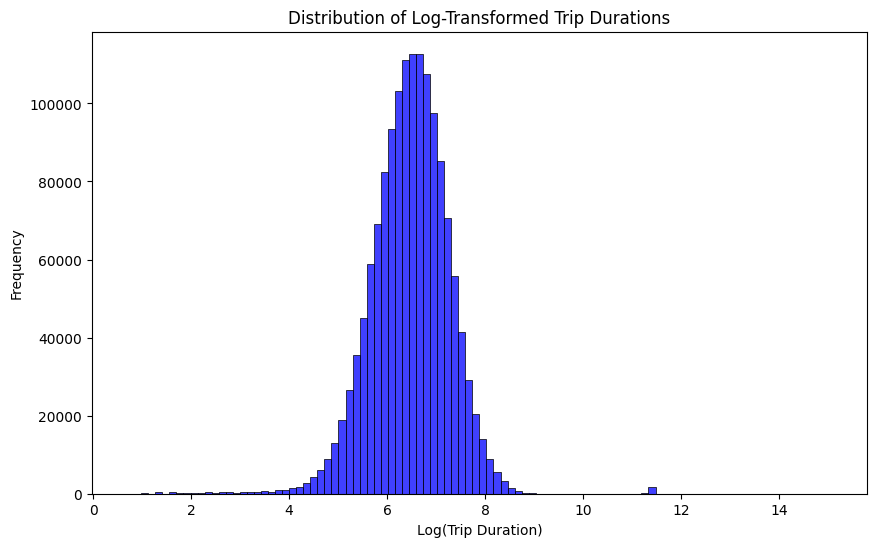

In [7]:
# Data Visualization: Distribution of Trip Durations
# Set up the figure size for the histogram
plt.figure(figsize=(10, 6))

# Create a histogram for log-transformed trip durations to visualize their distribution
sns.histplot(np.log(train['trip_duration'].values + 1), kde=False, bins=100, color='blue')

# Setting the title and labels for the histogram
plt.title('Distribution of Log-Transformed Trip Durations')
plt.xlabel('Log(Trip Duration)')
plt.ylabel('Frequency')

# Display the plot
plt.show()

# Exploring Trip Distance Distribution

Understanding the distribution of trip distances is crucial for modeling taxi trip durations accurately. By visually analyzing the trip distances, we aim to gain insights into the common ranges of travel and identify any patterns or outliers that could influence our predictive models. Focusing on the most common distances allows us to tailor our model to the typical scenarios encountered in the dataset.

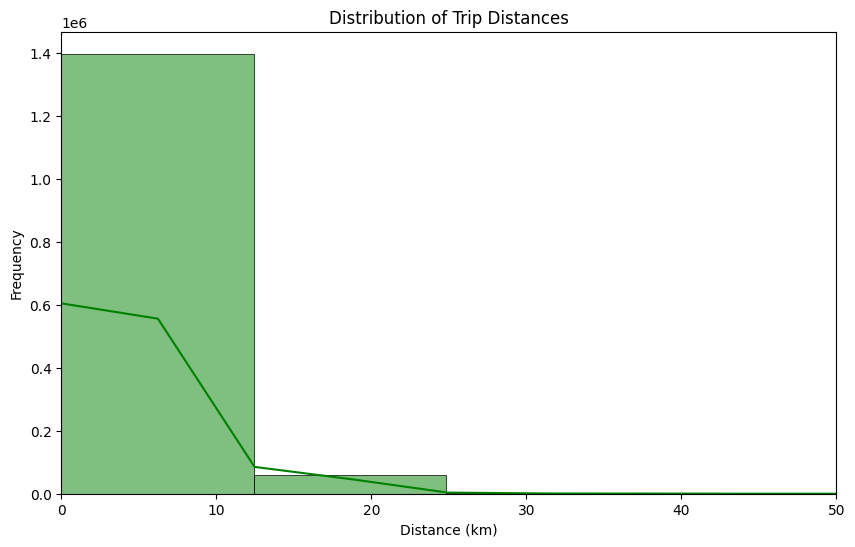

In [8]:
# Visualize the Distribution of Trip Distances
# Initialize the figure with a specified size
plt.figure(figsize=(10, 6))

# Plot a histogram for trip distances with a kernel density estimate to understand the distribution
sns.histplot(train['distance'].values, kde=True, bins=100, color='green')

# Set the plot title and axis labels
plt.title('Distribution of Trip Distances')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')

# Limit the x-axis to focus on the most common trip distances for better clarity
plt.xlim(0, 50)

# Display the histogram
plt.show()

# Outlier Removal and Feature Creation for Enhanced Model Accuracy

Managing outliers and creating new features are essential steps in preparing our dataset for more accurate predictions. This section focuses on identifying and removing outliers in trip distances and speeds, and introducing a 'speed' feature that could provide valuable insights for our predictive model.

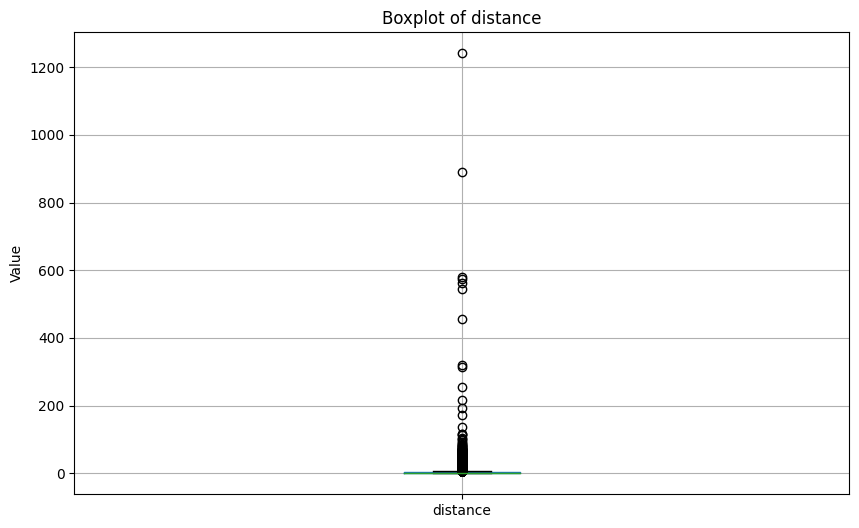

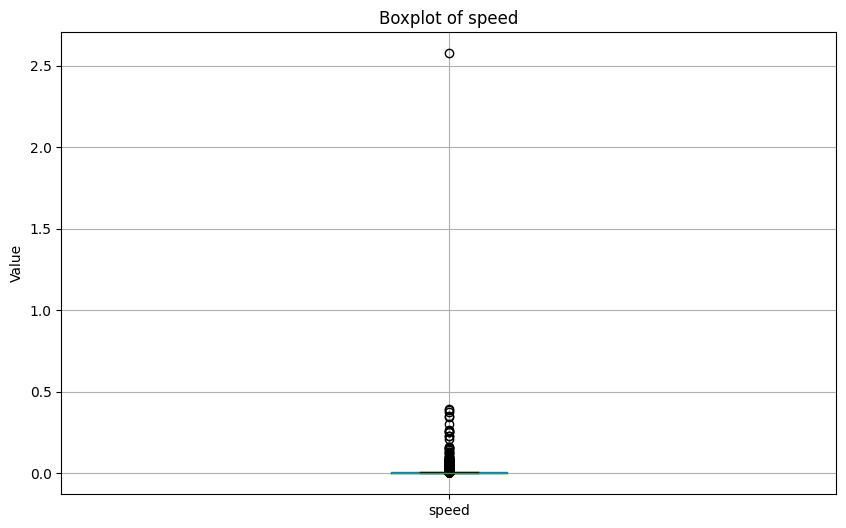

In [9]:

# Define a function to visualize outliers using boxplots
def visualize_outliers(data, column_name):
    plt.figure(figsize=(10, 6))
    data.boxplot(column=[column_name])
    plt.title(f'Boxplot of {column_name}')
    plt.ylabel('Value')
    plt.show()

# Define a function to remove outliers based on a specified threshold
def remove_outliers(data, column_name, threshold):
    condition = data[column_name] < threshold
    return data[condition]

# Define a function to create a new feature
def create_speed_feature(data):
    data['speed'] = data['distance'] / data['trip_duration']
    return data

# Visualize Distance Outliers
visualize_outliers(train, 'distance')

# Remove Distance Outliers
train = remove_outliers(train, 'distance', 200)  # Removing trips longer than 200 km

# Create Speed Feature
train = create_speed_feature(train)

# Visualize Speed Feature
visualize_outliers(train, 'speed')

# Remove Speed Outliers
train = remove_outliers(train, 'speed', 30)  # Removing speeds greater than 30 km/h

# Drop the 'speed' column after outlier removal
train.drop(['speed'], axis=1, inplace=True)


# Preparing Data for Predictive Modeling

The final step before building our predictive model involves preparing the dataset by selecting relevant features and setting up the training and testing data. This step is crucial for ensuring that our model is trained on the right inputs and can accurately predict the target variable, which in this case is the log-transformed trip duration.

In [10]:
# Define the feature columns to be used for modeling
feature_cols = ['passenger_count', 'pickup_longitude', 'pickup_latitude',
                'dropoff_longitude', 'dropoff_latitude', 'N', 'Y', 'month',
                'week', 'weekday', 'hour', 'minute_oftheday', 'distance', 'direction']

# Prepare the training data with selected features
x_train = train[feature_cols]

# Prepare the target variable by applying log transformation to trip duration for normalization
y_train = np.log1p(train['trip_duration'])

# Prepare the testing data with the same set of features as the training data
x_test = test[feature_cols]

# Model Training with XGBoost

Leveraging the power of XGBoost, we proceed to train our predictive model. XGBoost is renowned for its efficiency and effectiveness in regression tasks, making it an ideal choice for predicting taxi trip durations. This section outlines the process of splitting the data, defining the model parameters, and training the model to achieve optimal performance.

In [11]:
# Import necessary libraries for model training
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Split the training data into training and validation sets to evaluate performance
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=1)
# Further split the validation set for cross-validation
Xcv, Xv, Zcv, Zv = train_test_split(x_valid, y_valid, test_size=0.4, random_state=1)

# Prepare the data for XGBoost
data_tr = xgb.DMatrix(x_train, label=y_train)
data_cv = xgb.DMatrix(Xcv, label=Zcv)

# Set up the evaluation list to watch performance
evallist = [(data_tr, 'train'), (data_cv, 'valid')]

# Define model parameters
params = {
    'max_depth': 10,                   # Maximum depth of a tree, controls over-fitting
    'objective': 'reg:squarederror',   # Objective function for regression tasks
    'eta': 0.05,                       # Learning rate, prevents overfitting
    'subsample': 0.8,                  # Fraction of observations to be randomly sampled for each tree
    'colsample_bylevel': 1,            # Subsample ratio of columns for each level
    'min_child_weight': 10,            # Minimum sum of instance weight needed in a child
    'nthread': 3                       # Number of parallel threads used to run XGBoost
}


# Train the model
model = xgb.train(params, data_tr, num_boost_round=2000, evals=evallist, early_stopping_rounds=50, verbose_eval=200)

[0]	train-rmse:0.76979	valid-rmse:0.76296
[200]	train-rmse:0.36439	valid-rmse:0.38699
[400]	train-rmse:0.34292	valid-rmse:0.38169
[600]	train-rmse:0.32760	valid-rmse:0.38009
[800]	train-rmse:0.31582	valid-rmse:0.37910
[1000]	train-rmse:0.30551	valid-rmse:0.37851
[1200]	train-rmse:0.29685	valid-rmse:0.37810
[1400]	train-rmse:0.28840	valid-rmse:0.37779
[1474]	train-rmse:0.28557	valid-rmse:0.37776


In [12]:
# Display the best score and the corresponding number of boosting rounds
print(f'score = {model.best_score:.5f}, n_boost_round = {model.best_iteration}. \n')

# Generate predictions for the test set using the best iteration
data_test = xgb.DMatrix(x_test)
z_test = model.predict(data_test)

# Convert log-transformed predictions back to original scale
y_pred = np.exp(z_test) - 1
print(y_pred[:10])

score = 0.37774, n_boost_round = 1424. 

[ 746.3736   613.06903  436.03415  895.6182   448.16806  887.7245
 1418.5189   960.0476  2894.6736   499.6812 ]


# Predictive Error Analysis
Predictive error analysis is crucial in understanding how well our model is performing and identifying areas for improvement. By comparing the predicted values against the real values, we can calculate the residuals, which are the differences between these sets of values. Analyzing these residuals helps us identify patterns of overestimation or underestimation by the model.



### Step 1: Calculate Predictions for the Validation Set
First, we will generate predictions for the validation set using our trained model. This step is necessary to have a set of predicted values that we can compare against the actual values.

In [13]:
# Preparing the validation data for XGBoost
data_valid = xgb.DMatrix(x_valid)

# Generating predictions for the validation set
y_pred_valid = model.predict(data_valid)

# Note: y_valid and y_pred_valid are assumed to be log-transformed here


### Step 2: Calculate Residual Errors
Next, we calculate the residual errors in both the log scale (as our model operates on log-transformed targets for normalization) and the original scale (to interpret the errors in the same units as the target variable).

In [14]:
# Calculating residual errors in log scale
errors_log_scale = y_valid - y_pred_valid

# Converting residual errors back to original scale for easier interpretation
errors_original_scale = np.exp(y_valid) - np.exp(y_pred_valid)


# Visualization of Residual Errors
Visualizing the distribution of residual errors and their relationship with the predicted values provides insights into the model's performance. It helps in identifying systematic biases, outliers, or specific areas where the model might be underperforming.

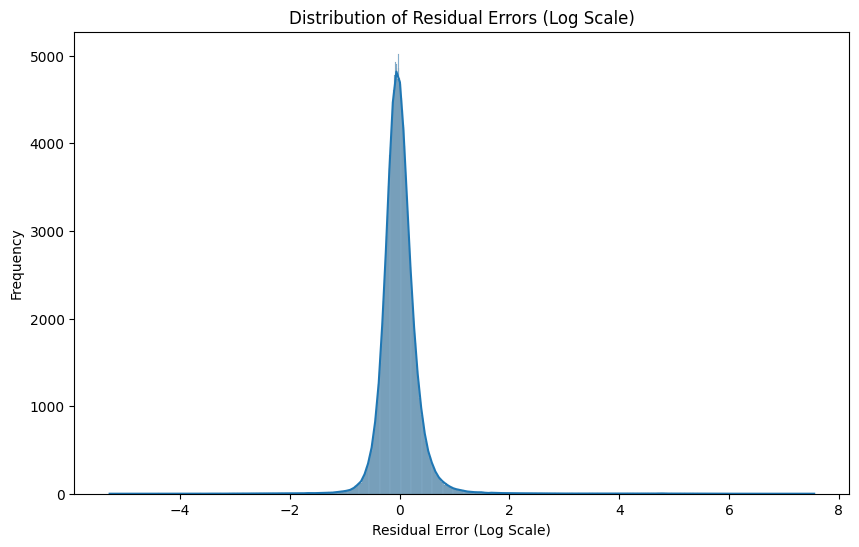

In [15]:
# Histogram of residual errors in log scale
plt.figure(figsize=(10, 6))
sns.histplot(errors_log_scale, kde=True)
plt.title('Distribution of Residual Errors (Log Scale)')
plt.xlabel('Residual Error (Log Scale)')
plt.ylabel('Frequency')
plt.show()


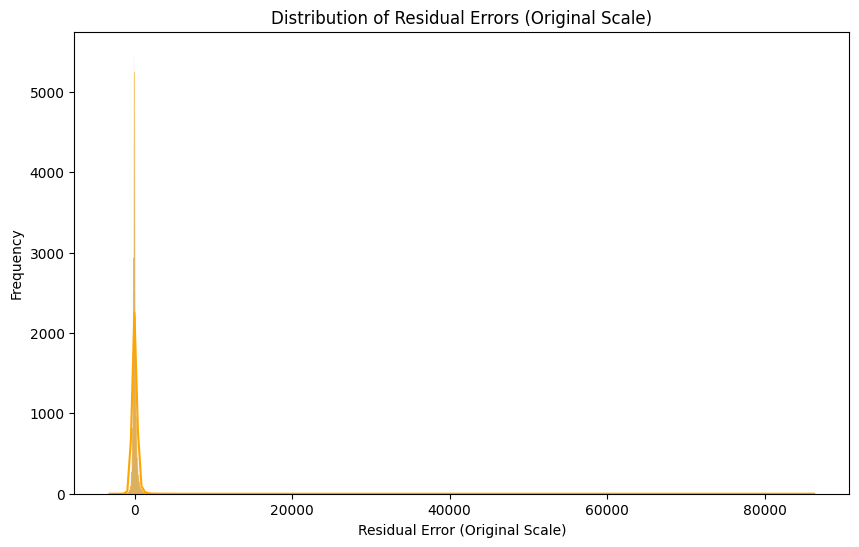

In [16]:
# Histogram of residual errors in original scale
plt.figure(figsize=(10, 6))
sns.histplot(errors_original_scale, kde=True, color='orange')
plt.title('Distribution of Residual Errors (Original Scale)')
plt.xlabel('Residual Error (Original Scale)')
plt.ylabel('Frequency')
plt.show()


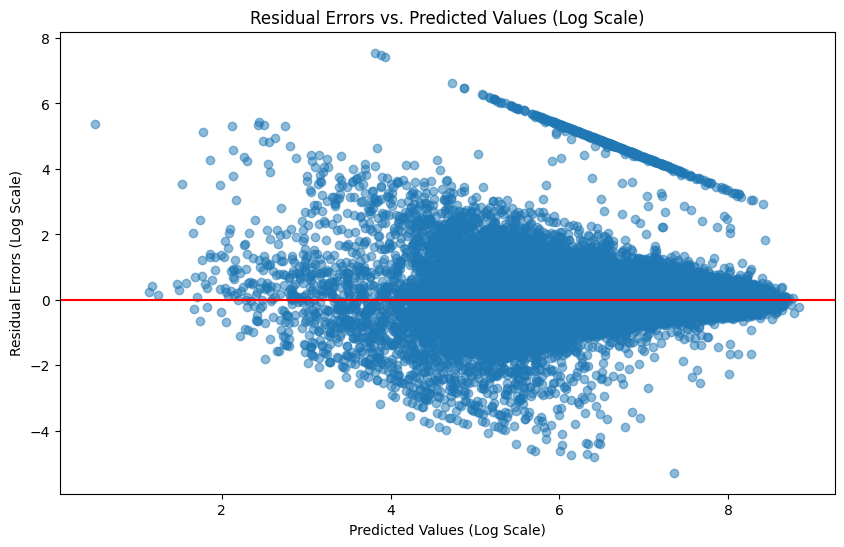

In [17]:
# Scatter plot of residual errors vs. predicted values in log scale
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_valid, errors_log_scale, alpha=0.5)
plt.title('Residual Errors vs. Predicted Values (Log Scale)')
plt.xlabel('Predicted Values (Log Scale)')
plt.ylabel('Residual Errors (Log Scale)')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()


# Visualizing Feature Importance
In this section, we've focused on extracting and visualizing the importance of different features used in our XGBoost model, which predicts taxi trip durations. Understanding feature importance is crucial as it reveals which features most significantly impact the model's predictions, helping us interpret the model's behavior and guide further model improvements and feature engineering efforts.

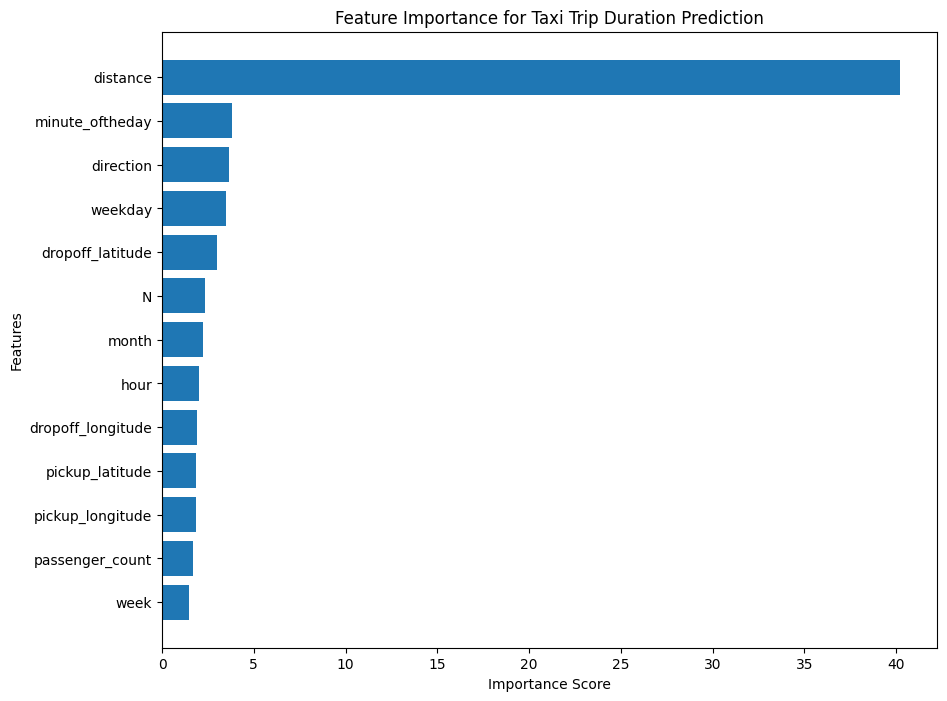

In [18]:
# Importing necessary libraries
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming 'model' refers to your trained XGBoost model
# 'gain' indicates the improvement in accuracy brought by a feature to the branches it is on.

# Extract feature importance based on 'gain'
feature_importance = model.get_score(importance_type='gain')

# Sort the features by their importance scores in descending order
sorted_importance = sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)
# Separating the feature names and their importance scores
features, importances = zip(*sorted_importance)

# Creating a horizontal bar chart to visualize the feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), features)  # Label y-axis with feature names
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important feature at the top
plt.xlabel('Importance Score')  # Label for the x-axis
plt.ylabel('Features')  # Label for the y-axis
plt.title('Feature Importance for Taxi Trip Duration Prediction')  # Chart title
plt.show()



# Prediction and Submission File Creation

After training our model with XGBoost and generating predictions for the test set, the next step is to prepare our submission file. This file will contain our predictions in the format required by the competition, enabling us to submit our results and see how our model performs on unseen data.

In [19]:
# Create a DataFrame for submission
submission = pd.DataFrame({'id': test['id'], 'trip_duration': y_pred})

# Save the submission file
submission.to_csv('submission.csv', index=False)

# Display the first few rows of the submission to ensure it's formatted correctly
submission.head()

,id,trip_duration
0,id3004672,746.373596
1,id3505355,613.069031
2,id1217141,436.034149
3,id2150126,895.618225
4,id1598245,448.168060
